In [34]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
from pandasql import sqldf
import xml.etree.ElementTree as ET
psql= lambda q: sqldf(q, globals())

# creating connection

In [2]:
with sqlite3.connect('F:/Abhyas/WSU/Sem 3/Data Science/Project/Data/database.sqlite') as con:
    matches = pd.read_sql_query("SELECT * from Match", con)
    team= pd.read_sql_query("SELECT * from Team", con)
    player= pd.read_sql_query("SELECT * from Player", con)
    leagues = pd.read_sql_query("SELECT * from League", con)

# getting desired data

# Exploratory Data Analysis and Data Cleaning

In [3]:
"""
goal description
'n': normal goals
'p': penalties
'o': own goals
'npm': missed penalty 
'dg', 'rp' - goals not counted because of offside
"""

def getPlayersThatScored(xmlInfo):
    if xmlInfo == None:
        return None
    
    scorers = []
    root = ET.fromstring(xmlInfo)
    for child in root:
        player = child.find('player1')
        goal_type = child.find('goal_type')
        
        if player != None and goal_type != None:
            if goal_type.text not in ['dg', 'npm', 'o', 'rp']:
                scorers.append(player.text)  
                
    if len(scorers) > 0:
        return ';'.join(scorers)
    else:
        return None

def getPlayersThatAssisted(xmlInfo):
    if xmlInfo==None:
        return None
    assisted=[]
    root = ET.fromstring(xmlInfo)
    for child in root:
        assist= child.find('player2')
        goal_type = child.find('goal_type')

        if assist != None and goal_type != None:
            if goal_type.text not in ['dg', 'npm', 'o', 'rp']:
                assisted.append(assist.text) 
                
    if len(assisted) > 0:
        return ';'.join(assisted)
    else:
        return None

In [4]:
def getStatsPerTeam(match_info):
    xmlInfo = match_info[0]
    if xmlInfo == None:
        return [None, None]
    
    home_team_stats = 0
    away_team_stats = 0
    
    root = ET.fromstring(xmlInfo)
    for child in root:
        team = child.find('team')
        if team != None:
            if int(team.text) == match_info['home_team_id']:
                home_team_stats = home_team_stats + 1
            elif int(team.text) == match_info['away_team_id']:
                away_team_stats = away_team_stats + 1
                
    return [home_team_stats, away_team_stats]

def getPossessionPerTeam(match_info):
    xmlInfo = match_info[0]
    if xmlInfo == None:
        return [None, None]
    
    home_team_pos = 0
    away_team_pos = 0
    
    root = ET.fromstring(xmlInfo)
    for child in root:
        elapsed= child.find('elapsed')
        awaypos = child.find('awaypos')
        homepos = child.find('homepos')

        if int(elapsed.text) == 90:
            home_team_pos= int(homepos.text)
            away_team_pos= int(awaypos.text)
                
    return [home_team_pos, away_team_pos]

# Get Average Age of the team

In [5]:
def getAge(goals_and_assists, season):
    query= """ select p.player_api_id, p.birthday from player as p
INNER JOIN (select * from goals_and_assists) as g 
on p.player_api_id= g.id"""
    ageDf= psql(query)
    ageDf['season']= int(season.split('/')[0])
    ageDf['birthday'] = pd.to_datetime(ageDf['birthday'])
    ageDf['birth_year']= pd.DatetimeIndex(ageDf['birthday']).year
    ageDf['age']= ageDf['season'] - ageDf['birth_year']
    avg= ageDf['age'].mean()
    return float('%.2f' %avg)

# Winning rate of a season

In [6]:
def getPoints(team_matches, name):
    team_matches['result']= team_matches['home_team_goal']- team_matches['away_team_goal']
    query= """ select team_api_id from team where team_long_name= '{}' """.format(name)
    id= psql(query)
    id= id['team_api_id'][0]
    points=[]
    prev=0
    win=0
    loss=0
    draw=0
    
    for index, row in team_matches.iterrows():
        if(row['result'] > 0 and row['home_team_id'] == id):
            points.append(prev+3)
            prev= prev+3
            win+=1
        
        elif(row['result'] < 0 and row['away_team_id'] == id):
            points.append(prev+3)
            prev= prev+3
            win+=1
        
        elif(row['result'] < 0 and row['home_team_id'] == id):
            points.append(prev+0)
            prev= prev+0
            loss+=1
            
        elif(row['result'] > 0 and row['away_team_id'] == id):
            points.append(prev+0)
            prev= prev+0
            loss+=1
            
        elif(row['result'] == 0):
            points.append(prev+1)
            prev= prev+1
            draw+=1     
    return points,win,loss,draw

# Plot Results

In [32]:
def plotResults(team_matches):
    plt.plot(team_matches.points)
    plt.xlabel('Game Day')
    plt.ylabel('points')
    plt.title('Results Plot')
    plt.savefig('results.png', bbox_inches='tight')
    plt.show()
    plt.close()
    

def plotWLD(win,loss,draw):
    width=0.5
    res= ['win', 'loss', 'draw']
    inp= [win, loss, draw]
    plt.bar(res, inp, width, color='g')
    plt.xlabel('Season Stats')
    plt.ylabel('Total')
    plt.title('W-L-D for the season')
    plt.savefig('wld.png', bbox_inches='tight')
    plt.show()
    plt.close()
    

In [37]:
def getUserInput( goals, assists, players):
    season = input("Which season do you want to look up")
    
    input_option = input("How do you want to search for team name 1) Full Team Name 2) Abbreviated Name ")
    team_query = ""
    
    if input_option == str(2):
        name = input("Please enter abbreviated name")
        team_query = "team_short_name == '%s'" % name
        query= """ select m.league_id, m.season, m.stage, m.date, m.match_api_id, m.home_team_api_id, m.away_team_api_id, m.home_team_goal, m.away_team_goal, m.goal, m.shoton, m.shotoff, m.foulcommit, m.card, m.cross, m.corner, m.possession from matches as m 
        INNER JOIN (select * from team where team_short_name= '%s') as t 
        on m.home_team_api_id= t.team_api_id or m.away_team_api_id= t.team_api_id""" % name
        #print(team_query)
    elif input_option == str(1):
        name = input("Please enter full name")
        team_query = "team_long_name == '%s'" % name
        query= """ select m.league_id, m.season, m.stage, m.date, m.match_api_id, m.home_team_api_id, m.away_team_api_id, m.home_team_goal, m.away_team_goal, m.goal, m.shoton, m.shotoff, m.foulcommit, m.card, m.cross, m.corner, m.possession from matches as m 
        INNER JOIN (select * from team where team_long_name= '%s') as t 
        on m.home_team_api_id= t.team_api_id or m.away_team_api_id= t.team_api_id""" %name
        #print(team_query)

    team_api_id = team.query(team_query)['team_api_id'].to_string(index=False)
    #print(team_api_id)
    detailed_query = "home_team_api_id == " + team_api_id + " and season == '{}'".format(season) 
    #print(query)
    
    matches_with_players = matches.query(detailed_query)
    team_matches = psql(query)
    team_matches= team_matches.rename(columns= {'home_team_api_id': 'home_team_id', 'away_team_api_id': 'away_team_id', 'match_api_id': 'match_id'})
    team_matches = team_matches.query("season == '{}'".format(season))
    
    team_matches['scored_by']= team_matches['goal'].apply(getPlayersThatScored)
    #get assists
    team_matches['assisted_by']= team_matches['goal'].apply(getPlayersThatAssisted)

    #get cards
    team_matches[['cards_home_team', 'cards_away_team']] = team_matches[['card', 'home_team_id', 'away_team_id']].apply(getStatsPerTeam, axis = 1, result_type='expand')
    # get corners
    team_matches[['corners_home_team', 'corners_away_team']] = team_matches[['corner', 'home_team_id', 'away_team_id']].apply(getStatsPerTeam, axis = 1, result_type='expand')
    #get shoton
    team_matches[['shoton_home_team', 'shoton_away_team']] = team_matches[['shoton', 'home_team_id', 'away_team_id']].apply(getStatsPerTeam, axis = 1, result_type='expand')
    #get shotoff
    team_matches[['shotoff_home_team', 'shotoff_away_team']] = team_matches[['shotoff', 'home_team_id', 'away_team_id']].apply(getStatsPerTeam, axis = 1, result_type='expand')
    #get shotoff
    team_matches[['cross_home_team', 'cross_away_team']] = team_matches[['cross', 'home_team_id', 'away_team_id']].apply(getStatsPerTeam, axis = 1, result_type='expand')
    #get possession
    team_matches[['possession_home_team', 'possession_away_team']]= team_matches[['possession', 'home_team_id', 'away_team_id']].apply(getPossessionPerTeam, axis = 1, result_type='expand')

    #drop XML Columns
    team_matches= team_matches.drop(columns= ['goal','card', 'corner', 'shoton', 'shotoff', 'cross', 'foulcommit', 'possession'])
    #handle missing values for possession
    team_matches.loc[team_matches.possession_home_team == 0, 'possession_home_team']= 50
    team_matches.loc[team_matches.possession_away_team == 0, 'possession_away_team']= 50
    
    #print team
    for i in range(1,12):
        print("Player at position at " + str(i) + " for " + name)
        print(" ")
        for x in matches_with_players['home_player_'+str(i)].unique():
            sql = "player_api_id == " + str(x)
            
            if not np.isnan(x):
                player_name = player.query(sql).sort_values(by='player_name')['player_name'].to_string(index = False)
            
                print(player_name)
                goals[x] = 0
                assists[x] = 0
                players[x] = player_name
                #print(playerAttr.query(sql).iloc[0])
                print(" ")
        print(" ")

    
    for x in range(len(team_matches)):
        score_information = team_matches.iloc[x].scored_by
        assist_information = team_matches.iloc[x].assisted_by

        if score_information != None:
            for scorer in score_information.split(";"):
                if int(scorer) in goals.keys():
                    goals[int(scorer)] = goals[int(scorer)] + 1
        if assist_information != None:
            for assister in assist_information.split(";"):
                if int(assister) in assists.keys():
                    assists[int(assister)] = assists[int(assister)] + 1
    
    #get goals and assists for a season
    global goals_and_assists
    data = {'id': list(players.keys()),'name': list(players.values()), 'goals': list(goals.values()), 'assists': list(assists.values())}
    goals_and_assists = pd.DataFrame.from_dict(data)
    
    points,win,loss,draw = getPoints(team_matches, name)
    team_matches['points']= points
    
    category= ['win','loss','draw']
    result= [str(win),str(loss),str(draw)]
    # opening the csv file in 'w+' mode 
    file = open('wld2.csv', 'w+', newline ='') 
    # writing the data into the file 
    with file:     
        write = csv.writer(file) 
        write.writerows(category)   
        write.writerows(result)
    file.close()
    
    #print stats
    plotResults(team_matches)
    plotWLD(win,loss,draw)
    print("Total wins in Season {} : {}".format(season, win))
    print("Total loss in Season {} : {}".format(season, loss))
    print("Total draw in Season {} : {}".format(season, draw))
    print("Total points scored for the season {}: {}".format(season, points[len(points)-1]))
    avg= getAge(goals_and_assists, season)
    print("Average age of squad: {}".format(avg))
    print("Highest Goal Scorer:")
    print(goals_and_assists[['name','goals']].sort_values(by= 'goals',ascending=False).head(3))
    print("Highest assists:")
    print(goals_and_assists[['name','assists']].sort_values(by= 'assists',ascending=False).head(3))
    
    return goals_and_assists

# Get User Input Function

Which season do you want to look up2008/2009
How do you want to search for team name 1) Full Team Name 2) Abbreviated Name 1
Please enter full nameManchester United


<ipython-input-37-b67441712f58>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches['scored_by']= team_matches['goal'].apply(getPlayersThatScored)
<ipython-input-37-b67441712f58>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches['assisted_by']= team_matches['goal'].apply(getPlayersThatAssisted)
C:\ProgramData\Anaconda3\envs\python38\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Player at position at 1 for Manchester United
 
 Edwin van der Sar
 
 Tomasz Kuszczak
 
 
Player at position at 2 for Manchester United
 
 Wes Brown
 
 Rafael
 
 Gary Neville
 
 John O'Shea
 
 Rio Ferdinand
 
 
Player at position at 3 for Manchester United
 
 Rio Ferdinand
 
 Nemanja Vidic
 
 Gary Neville
 
 Patrice Evra
 
 
Player at position at 4 for Manchester United
 
 Nemanja Vidic
 
 Jonny Evans
 
 Rafael
 
 
Player at position at 5 for Manchester United
 
 Patrice Evra
 
 John O'Shea
 
 Nemanja Vidic
 
 
Player at position at 6 for Manchester United
 
 Darren Fletcher
 
 Cristiano Ronaldo
 
 Ji-Sung Park
 
 
Player at position at 7 for Manchester United
 
 Michael Carrick
 
 Darren Fletcher
 
 Paul Scholes
 
 
Player at position at 8 for Manchester United
 
 Paul Scholes
 
 Anderson
 
 Darren Fletcher
 
 Michael Carrick
 
 Ryan Giggs
 
 
Player at position at 9 for Manchester United
 
 Ryan Giggs
 
 Nani
 
 Ji-Sung Park
 
 Cristiano Ronaldo
 
 
Player at position at 10 for Manch

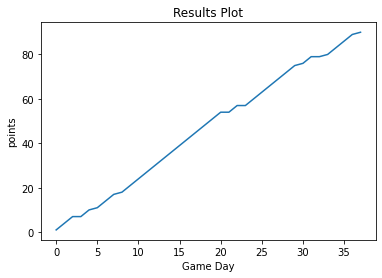

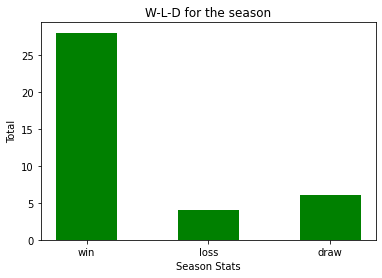

Total wins in Season 2008/2009 : 28
Total loss in Season 2008/2009 : 4
Total draw in Season 2008/2009 : 6
Total points scored for the season 2008/2009: 90
Average age of squad: 26.45
Highest Goal Scorer:
                  name  goals
11   Cristiano Ronaldo     18
21        Wayne Rooney     12
20    Dimitar Berbatov      9
Highest assists:
                 name  assists
20   Dimitar Berbatov       10
21       Wayne Rooney        7
16         Ryan Giggs        7


In [84]:
#input dictionaries
goals = {}
assists = {}
players = {}

goals_and_assists= getUserInput( goals, assists, players )

In [83]:
matches.query(' league_id == 1729 ').shoton.iloc[0]

'<shoton><value><stats><blocked>1</blocked></stats><event_incident_typefk>61</event_incident_typefk><elapsed>3</elapsed><subtype>blocked_shot</subtype><player1>24154</player1><sortorder>0</sortorder><team>10260</team><n>253</n><type>shoton</type><id>378828</id></value><value><stats><shoton>1</shoton></stats><event_incident_typefk>154</event_incident_typefk><elapsed>7</elapsed><subtype>header</subtype><player1>24157</player1><sortorder>2</sortorder><team>10260</team><n>258</n><type>shoton</type><id>378866</id></value><value><stats><shoton>1</shoton></stats><event_incident_typefk>153</event_incident_typefk><elapsed>14</elapsed><subtype>shot</subtype><player1>30829</player1><sortorder>1</sortorder><team>10260</team><n>274</n><type>shoton</type><id>378922</id></value><value><stats><shoton>1</shoton></stats><event_incident_typefk>153</event_incident_typefk><elapsed>14</elapsed><subtype>shot</subtype><player1>30373</player1><sortorder>2</sortorder><team>10260</team><n>279</n><type>shoton</ty

'1728    <goal><value><comment>n</comment><stats><goals...\nName: goal, dtype: object'